# CPM Routing Optimization

# Load up the data 
* Demands = number of unpaid + expired
* locations = x,y coordinates of block
* labels = block id
* cars = average number of cars

## Data is from March 2017 to March 2018

In [1]:
import csv
import numpy as np
import os
demands = []
labels = []
locations = []
firstLine = True
limiter = 9999999
counter = 0
cars = []
megaCluster = []
streetSide = []
streetName = []
dataFolder = "data"
with open(os.path.join(dataFolder,'3.16.Data.csv'), 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if counter < limiter: #this is just a cap to QA the model with fewer locations
            if firstLine:
                firstLine = False
            else:
                latLong = []
                latLong.append(float(row[23]))
                latLong.append(float(row[24]))
                locations.append(latLong)
                labels.append(row[1])
                demands.append(float(row[26]))
                cars.append(float(row[27]))
                megaCluster.append(int(row[25]))
                streetSide.append(row[14])
                streetName.append(row[18].split(" ",1)[1])
                counter+=1


start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
zone = [int(x[4]) for x in labels]
np.bincount(np.array(zone))

array([   0, 1401,  456,  383,  662,  129,  685,  228,   15,   26])

In [2]:
import pandas as pd
dictionary = {'Block ID': labels, 'Unpaid and Expired Average': demands, 'Locations': locations}

df = pd.DataFrame.from_dict(dictionary)
df.head()

,Block ID,Locations,Unpaid and Expired Average
0,B101101,"[444454.5456, 4649832.168]",1.545455
1,B200401,"[446463.1853, 4637775.894]",0.732456
2,B200403,"[446316.7979, 4637773.449]",0.299539
3,B200405,"[446344.811, 4637777.506]",0.217593
4,B200406,"[446488.1358, 4637779.476]",0.327189


# Next step - find optimal clusters of blocks for car drop-off
## Plotting locations below

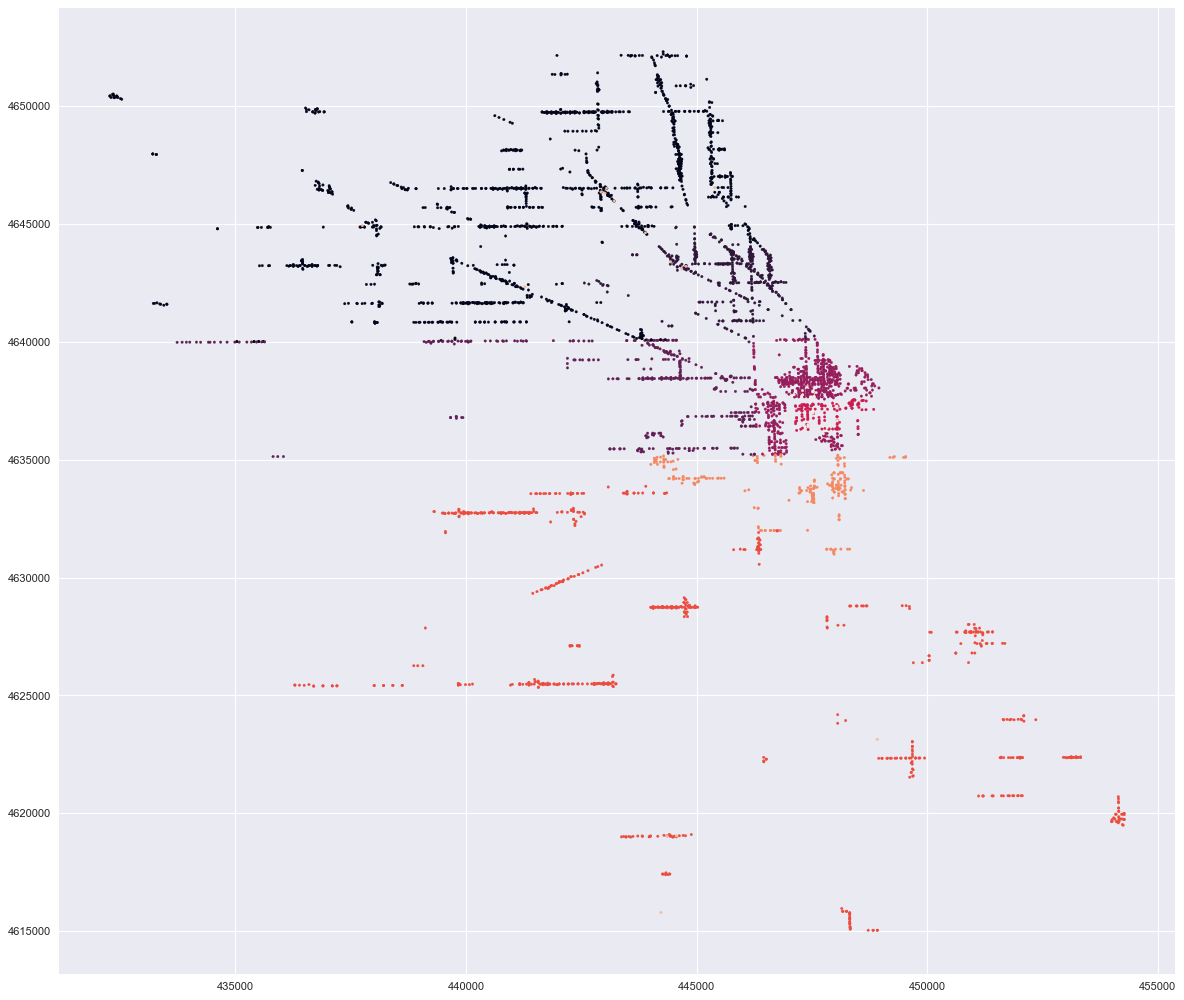

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
seed = 1234 # setting seed to keep results the same run to run
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter([x[0] for x in locations], [x[1] for x in locations], s=5, c=zone)
# plt.figure(figsize=(200,100))

# Below we are trying to find the optimal number of clusters. 
This is found by iterating through clusters 1-50 and looking at the average number of blocks + the average distance of blocks from the center starting point of the cluster.

# UPDATE 3.14.18:

K means had some overlapping clusters - now moving to a density based cluster to get the clusters to make more sense geographically

Cluster Sizes: [1099   63   94   97   68  129  182   64   99  419  539  158  100  874]


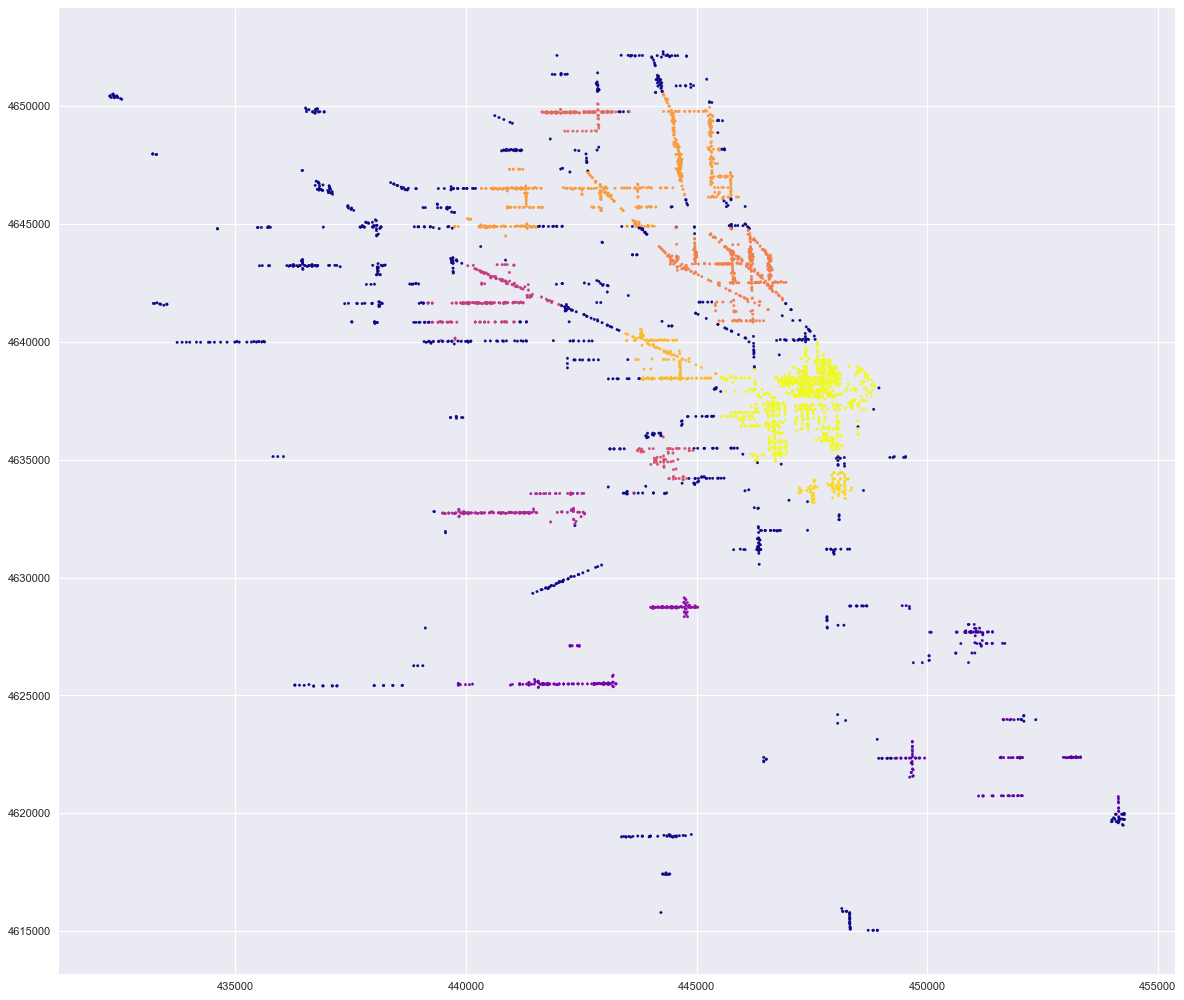

In [9]:
# Elbow chart
from scipy.cluster.vq import vq
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import hdbscan


X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))

clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
cluster_labels = clusterer.fit_predict(X)

hdbscanLabels = cluster_labels + 100 #IDS will be incremented by 100 - note that 99 aka -1 will use kmeans
cSizes = np.bincount(cluster_labels + 1)
print("Cluster Sizes: " + str(cSizes))

#need to find centroid of HDSCAN clusters

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

XX = np.column_stack((X, cluster_labels))
centers = []
for k in range(len(cSizes) - 1):
    ind = np.where(XX[:, 2] == k)
    locs = XX[ind, 0:1]
    cent = centeroidnp(locs)
    centers.append(cent)
centers = np.array(centers)
denseCenters = centers # save as another object
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=5, cmap='plasma')

# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# Using the idea of downtown 'mega-cluster' where individuals walk from the LAZ garage

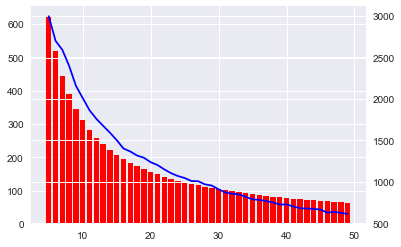

In [143]:
# omit from megacluster to find ideal clusters
mc = np.array(megaCluster)
distortions = []
avgBinsize = []
indexes = np.where(np.array(mc)[:] == 0)
Xzone = X[indexes]
K = range(5,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(Xzone)
    kmeanModel.fit(Xzone)
    distortions.append(sum(np.min(cdist(Xzone, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ Xzone.shape[0])
    centers = kmeanModel.cluster_centers_
    idx,_ = vq(Xzone,centers) #finding the number of blocks by cluster
    avgBinsize.append(np.average(np.bincount(idx)))
plt.bar(K, avgBinsize, color='r')
# for kb in zip(K,avgBinsize):|
#     plt.annotate('{}'.format(kb), xy=kb, textcoords='data')
axes2 = plt.twinx()
# print("Zone # {}".format(i))
plt.plot(K, distortions, 'bx-')
plt.show()
i+=1
# print(zip(K,avgBinsize, distortions))


# Now we are choosing the number of clusters and slicing the data by cluster
## kData is the data structure that will be used to hold the data by cluster, and eventually the solution
* center = the x,y coord that is the center of the cluster
* locations = the locations by cluster
* labels = block id by cluster
* cars = number of parked cars by cluster
* demand = number of unpaid + expired by cluster
* centralTerm = the blockID closest to the center

Cluster Sizes: [  0 194 102 136  39 198  62 109 173 152  97  69  80 138 362  79 107 170
 140  17 165  57  34  33  26  25  47 114  19  90  81]


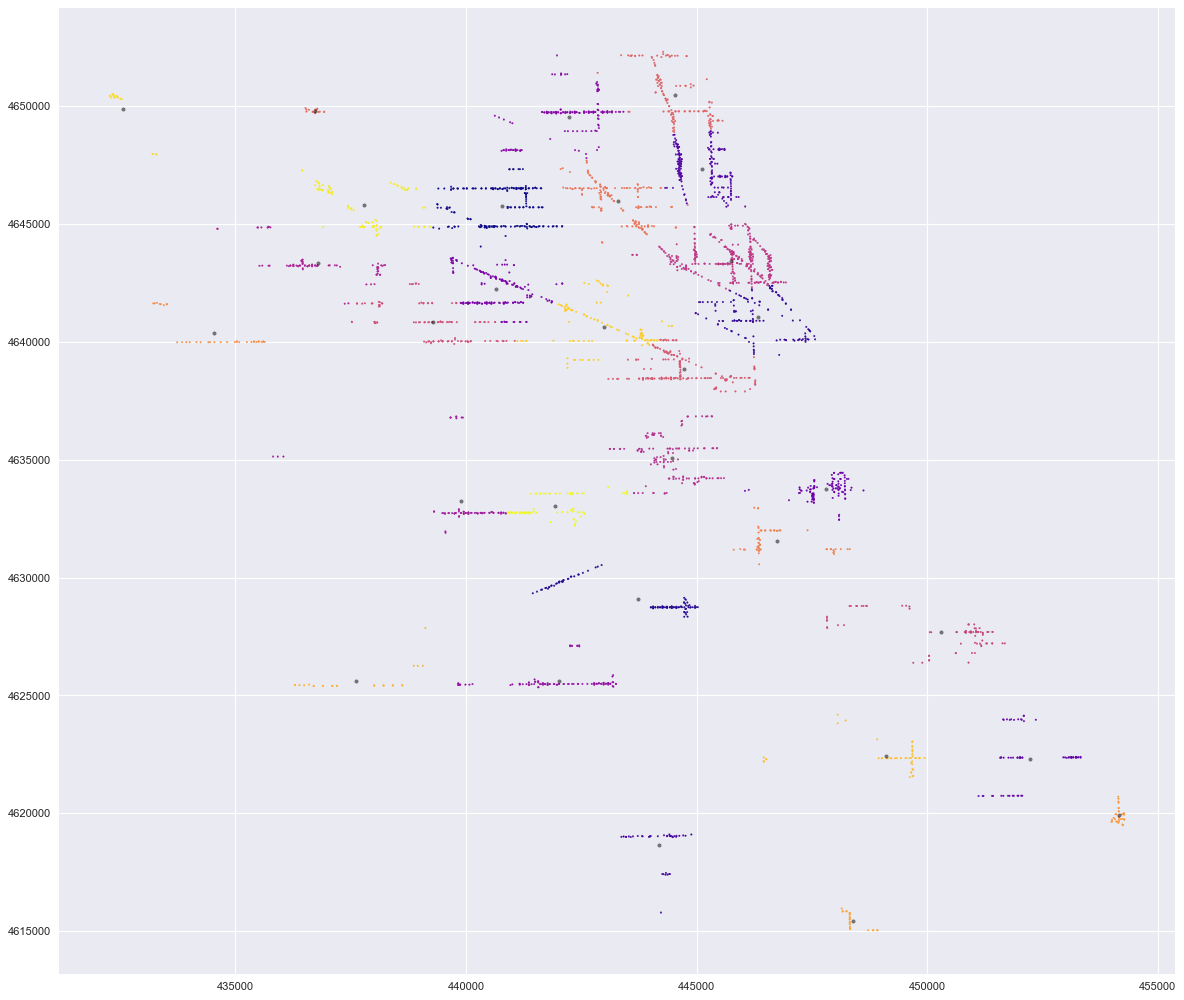

In [4]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

seed = 1234

fullData = {'locations': locations, 'labels': labels, 'cars': cars, 'demands': demands\
            , 'megacluster': megaCluster, 'streetName' : streetName, 'streetSide': streetSide}

fullDS = pd.DataFrame.from_dict(fullData)


nClusters = 30

kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
              'centralTerm': None} for key in range(nClusters)}

#now load up the megacluster first:

megaData = fullDS.loc[fullDS['megacluster'] == 1]
nonmegaData = fullDS.loc[fullDS['megacluster'] == 0]

megaDict = megaData.to_dict(orient='list')
nonMegaDict = nonmegaData.to_dict(orient='list')

X = np.array(zip([x[0] for x in nonMegaDict['locations']],[x[1] for x in nonMegaDict['locations']]))

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=nClusters, random_state=seed)
kmeans.fit(X)

kPred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kPred, s=2, cmap='plasma')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# print np.average(np.bincount(idx))
closest, _ = pairwise_distances_argmin_min(centers, X)
centerTerminals = [nonMegaDict['labels'][c] for c in closest]
# kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
#               'centralTerm': None} for key in range(nClusters)}
# kData = {}
for k in range(nClusters):
    klocations = []
    klabels = []
    kcars = []
    kdemand = []
    kstreet = []
    kside = []
    for loc, lab, car, dem, kp, sn, sd in zip(nonMegaDict['locations'], nonMegaDict['labels'],\
                                      nonMegaDict['cars'], nonMegaDict['demands'], kPred,\
                                     nonMegaDict['streetName'], nonMegaDict['streetSide']):
        if kp == k:
            klocations.append(loc)
            klabels.append(lab)
            kcars.append(car)
            kdemand.append(dem)
            kstreet.append(sn)
            kside.append(sd)
        
    kData[k].update({'center': centers[k], 'locations': klocations, 'labels': klabels, \
                    'cars': kcars, 'demand': kdemand, 'centralTerm': centerTerminals[k], \
                    'streetName': kstreet, 'streetSide': kside})
#     print(len(klocations))


stuffThatIsDrivingMeNutsWPython = {'center': [448476.6, 4636929], 'locations': megaDict['locations'], \
                 'labels': megaDict['labels'], 'cars' : megaDict['cars'], 'demand': megaDict['demands'],\
                             'centralTerm' : "LAZ GARAGE", 'streetName': megaDict['streetName'],\
                                   'streetSide' : megaDict['streetSide']}
kData.update({nClusters  : stuffThatIsDrivingMeNutsWPython})
            
# kData[0]

#add megacluster 

            
cSizes = np.bincount(kPred + 1)
print("Cluster Sizes: " + str(cSizes))
# centers

In [15]:
#save cluster data to csv
import datetime
import pandas as pd
now = datetime.datetime.now()
dataFolder = "output"
filename = os.path.join(dataFolder, "clusterFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv")

nonmegaData["clusterID"] = kPred.tolist()
megaData["clusterID"] = [nClusters ] * len(megaData)

df = nonmegaData.append(megaData)
# se = pd.Series(kPred)
# se2 = pd.Series(cluster_labels)
# df = pd.DataFrame(np.column_stack((kPred, hdbscanLabels, np.array(labels))), columns=["kMeans", "HDBScan", "Block ID"])
# df

df.to_csv(filename)

/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Street Crossing Function

* Short term - finding if there is one crossing immediatly
* Long term - finding the longer crossings

In [5]:
def ShortTermCrossing(xCurrent, yCurrent, sideCurrent, xLast, yLast, sideLast):
#     assign directions
    goSouth = yLast > yCurrent
    goNorth = yLast < yCurrent
    goEast = xLast < xCurrent
    goWest = xLast > xCurrent
    goSW = goSouth and goWest
    goSE = goSouth and goEast
    goNE = goNorth and goEast
    goNW = goNorth and goWest
    xWalk = abs(xCurrent - xLast)
    yWalk = abs(yCurrent - yLast)
    distance = xWalk + yWalk
    
        ##conditions for crossing n,s,e,w
    
    if sideLast == "N" and sideCurrent == "S" and goSouth:
        r=1
    elif sideLast == "S" and sideCurrent == "N" and goNorth:
        r=1
    elif sideLast == "E" and sideCurrent == "W" and goWest:
        r=1
    elif sideLast == "W" and sideCurrent == "E" and goEast:
        r=1
        
    ###SAME SIDES
    elif sideLast == "N" and sideCurrent == "N" and yWalk > 50
        r=1
    elif sideLast == "S" and sideCurrent == "S" and yWalk > 50
        r=1
    elif sideLast == "E" and sideCurrent == "E" and xWalk > 50
        r=1
    elif sideLast == "W" and sideCurrent == "W" and xWalk > 50
        r=1
        
        
    #diagonals
    elif sideLast == "N" and sideCurrent == "E" and (goSouth or goEast):
        r=1
    elif sideLast == "N" and sideCurrent == "W" and (goSouth or goWest):
        r=1
    elif sideLast == "S" and sideCurrent == "E" and (goNorth or goEast):
        r=1
    elif sideLast == "S" and sideCurrent == "W" and (goNorth or goWest):
        r=1
    elif sideLast == "W" and sideCurrent == "N" and (goEast or goNorth):
        r=1
    elif sideLast == "W" and sideCurrent == "S" and (goEast or goSouth):
        r=1
    elif sideLast == "E" and sideCurrent == "N" and (goWest or goNorth):
        r=1
    elif sideLast == "E" and sideCurrent == "S" and (goWest or goSouth):
        r=1

    else:
        r=0
    return r
        
def LongTermCrossings(blockSizeX, blockSizeY, xCurrent, yCurrent, xLast, yLast):
    xWalk = abs(xCurrent - xLast)
    yWalk = abs(yCurrent - yLast)
    xBlocks = math.floor(xWalk / blockSizeX)
    yBlocks = math.floor(yWalk / blockSizeY)
    return xBlocks + yBlocks
        

# Create objects and callback functions for optimization algorithm
* distance = manhattan distance function
* distanceCallback = distance function from previous to current block
* demandCallback = get the paid + unpaid for the current block
* ServiceTimeCallback = get the time per ticket written
* CarCheckCallback = get the time it takes to check each indivisual car
* travelTimeCallback = get the travel time from node to node assuming a speed
* totalTimeCallback = the total time for the block, adding the various time callbacks + block overhead time assumptions

## Update 3.25.18 - added street name/side callback
## Also updated the distance callback to include a distance penalty + time penalty



In [13]:
import math
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def distance(x1, y1, x2, y2):
    # Manhattan distance
    dist = abs(x1 - x2) + abs(y1 - y2)

    return dist

# Distance callback

class CreateDistanceCallback(object):
  """Create callback to calculate distances and travel times between points."""

  def __init__(self, locations, street_name, street_side, cross_penalty, blockSizeX, blockSizeY):
    """Initialize distance array."""
    num_locations = len(locations)
    self.matrix = {}
    self.crossings = {}

    for from_node in xrange(num_locations):
      self.matrix[from_node] = {}
      self.crossings[from_node] = {}
      for to_node in xrange(num_locations):
#             JSW: THIS ALLOWS O TRAVEL PENALTY FROM DEPOT
#         if from_node == depot or to_node == depot:
#           self.matrix[from_node][to_node] = 0
#         else:
          x1 = locations[from_node][0]
          y1 = locations[from_node][1]
          x2 = locations[to_node][0]
          y2 = locations[to_node][1]
          #self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)
          #### adding the street crossing penalty
          streetFrom = street_name[from_node]
          streetTo = street_name[to_node]
          sideFrom = street_side[from_node]
          sideTo = street_side[to_node]

#########changing up new street crossing function 3.30.18 JSW
          stXing = ShortTermCrossing(x2, y2, sideTo, x1, y1, sideFrom)
          ltXing = LongTermCrossings(blockSizeX, blockSizeY, x2, y2, x1, y1)
          totalCrossings = stXing + ltXing
          self.crossings[from_node][to_node] = totalCrossings
#           x_penalty = cross_penalty * totalCrossings
#############END OF DISTANCE BASED UPDATE
          self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)# + x_penalty

  def Distance(self, from_node, to_node):
     return self.matrix[from_node][to_node]
    
  def Crossings(self, from_node, to_node):
     return self.crossings[from_node][to_node]


# Demand callback
class CreateDemandCallback(object):
  """Create callback to get demands at location node."""

  def __init__(self, demands):
    self.matrix = demands

  def Demand(self, from_node, to_node):
    return self.matrix[from_node]


####STREET NAME ADDED 3/25/18

class CreateStreetCrossingCallback(object):
    
    def __init__(self, street_name, street_side, crossingPenalty, locations, blockSizeX, blockSizeY):
        self.matrix = zip(street_name, street_side, locations)
#         self.street_direction = street_direction
        self.crossing_penalty = crossingPenalty
        self.blockSizeX = blockSizeX
        self.blockSizeY = blockSizeY
    
    def CrossingPenalty(self, from_node, to_node):
          sideFrom = self.matrix[from_node][1]
          sideTo = self.matrix[to_node][1]
          x1 = self.matrix[from_node][2][0]
          y1 = self.matrix[from_node][2][1]
          x2 = self.matrix[to_node][2][0]
          y2 = self.matrix[to_node][2][1]
          stXing = ShortTermCrossing(x2, y2, sideTo, x1, y1, sideFrom)
          ltXing = LongTermCrossings(self.blockSizeX, self.blockSizeY, x2, y2, x1, y1)
          return self.crossing_penalty * (stXing + ltXing)
#             if self.matrix[from_node][0] == self.matrix[to_node][0]\
#             and self.matrix[from_node][1] != self.matrix[to_node][1]:
#                 return int(self.crossing_penalty)
#             else:
#                 return int(0)
#         except:
#             0
        
        
        
# Service time (proportional to demand) callback.
class CreateServiceTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, demands, time_per_demand_unit):
    self.matrix = demands
    self.time_per_demand_unit = time_per_demand_unit

  def ServiceTime(self, from_node, to_node):
#     return int(self.matrix[from_node] * self.time_per_demand_unit)
    return self.matrix[from_node] * self.time_per_demand_unit

######JSW ADD BLOCK OVERHEAD TIME

class CreateBlockOverheadTime(object):
  """Create callback to get overhead time for each block."""

  def __init__(self, overhead_time):
    self.matrix = demands
    self.overhead_time = overhead_time

  def BlockOverheadTime(self, from_node, to_node):
    return int(self.overhead_time)


####################

######JSW ADD NONVIOLATOR CHECK TIME
# Service time (proportional to demand) callback.
class CreateCarCheckTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, cars, time_per_car_unit):
    self.matrix = cars
    self.time_per_car_unit = time_per_car_unit

  def ServiceTime(self, from_node, to_node):
    return int(self.matrix[from_node] * self.time_per_car_unit)
#####################################

# Create the travel time callback (equals distance divided by speed).
class CreateTravelTimeCallback(object):
  """Create callback to get travel times between locations."""

  def __init__(self, dist_callback, speed):
    self.dist_callback = dist_callback
    self.speed = speed

  def TravelTime(self, from_node, to_node):
    travel_time = self.dist_callback(from_node, to_node) / self.speed
    return int(travel_time)
# Create total_time callback (equals service time plus travel time).
class CreateTotalTimeCallback(object):
  """Create callback to get total times between locations."""

  def __init__(self, service_time_callback, travel_time_callback, car_check_time_callback, \
              overhead_time_callback, street_crossing_callback):
    self.service_time_callback = service_time_callback
    self.travel_time_callback = travel_time_callback
    self.car_check_time_callback = car_check_time_callback
    self.overhead_time_callback = overhead_time_callback
    self.street_crossing_callback = street_crossing_callback

  def TotalTime(self, from_node, to_node):
    service_time = self.service_time_callback(from_node, to_node)
    travel_time = self.travel_time_callback(from_node, to_node)
    car_check_time = self.car_check_time_callback(from_node, to_node)
    overhead_time = self.overhead_time_callback(from_node, to_node)
    street_crossing_time = self.street_crossing_callback(from_node, to_node)
    return service_time + travel_time + car_check_time + overhead_time + street_crossing_time

def get_routes_array(assignment, num_routes, routing):
  # Get the routes for an assignent and return as a list of lists.
  routes = []
  for route_nbr in range(num_routes):
    node = routing.Start(route_nbr)
    route = []

    while not routing.IsEnd(node):
      node = assignment.Value(routing.NextVar(node))
      route.append(node)
    routes.append(route)
  return routes

In [14]:
#creating objects for function to work below
depot = 0
labs = ['a','b']
street_side = ["N", "E"]
street_name = ["a", "b"]

# Below is the optimization algorithm and function
## key parameters:
* locations = list of locations
* demands = paid + unpaid
* start times, end times = the time windows of a given block's availability... currently not used
* num_vehicles = number of enforcement agents
* search time limit = limit in ms of time to find a solution
* time per demand unit = time it takes to write a ticket
* speed = walking speed between blocks
* vehicle capacity = maximum tickets that can be written - not used aka: unlimited
* depot = the index of the block where everyone starts walking for their shift
* horizion = shift duration
* time per car unit = time it takes to check each car (regardles of if there is a ticket)
* labs = block ids
* cars = number of cars

# Updates to new parameters iteration 2, 3

* street name = list of street names, number stripped
* street side = N,S,E,W side of the street
* distance constraint = the total cap of distance an individual can walk in a cycle
* block size x, y = size in meters of a block, used to identify street crossings
* distanceCrossing penalty = this decides if we use distance or time as the penalty for crossing streets, default is distance
* street crossing penalty = the time in seconds we penalize street crossings. It can either be translated into additional distance in the model or additional time. adding in to distance creates some double counting of travel time problems


In [15]:
def parktimize(locations=locations, demands=demands, start_times=start_times, end_times=end_times, \
         num_vehicles=30, search_time_limit = 2000,\
        horizon = 6.5 * 3600, time_per_demand_unit = 3*60, speed = 1.34, VehicleCapacity = 999999,\
        depot = depot, time_per_car_unit=1*60, labs=labs, cars=cars, blockOverhead = 2 * 60, \
         street_crossing_penalty = 60, street_name=street_name, street_side=street_side, \
         distance_constraint = 20922, blockSizeX = int(0.3048 * 600), blockSizeY = int(0.3048 * 600) ,\
         distanceCrossingPenalty = False):

  num_locations = len(locations)

  if num_locations > 0:

    # The number of nodes of the VRP is num_locations.
    # Nodes are indexed from 0 to num_locations - 1. By default the start of
    # a route is node 0.
    routing = pywrapcp.RoutingModel(num_locations, num_vehicles, depot)
    search_parameters = pywrapcp.RoutingModel_DefaultSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING) ## added by jw for search
    search_parameters.time_limit_ms = search_time_limit #added by jsw
    search_parameters.first_solution_strategy = (
                                    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC) #added by jsw
    #JW ADD - make sure all nodes will be reached
    #routing.AddAllActive
    ## Added 3.28 for street crossing to be done by speed
    if distanceCrossingPenalty:
        cross_dist = street_crossing_penalty * speed
    else:
        cross_dist = 0
    # Callbacks to the distance function and travel time functions here.
    dist_between_locations = CreateDistanceCallback(locations, street_name, street_side, cross_dist, blockSizeX, \
                                                   blockSizeY)
    dist_callback = dist_between_locations.Distance
    crossing_callback = dist_between_locations.Crossings

    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    demands_at_locations = CreateDemandCallback(demands)
    demands_callback = demands_at_locations.Demand


    NullCapacitySlack = 0;
    fix_start_cumul_to_zero = True
    capacity = "Unpaid and Overdue"

    routing.AddDimension(demands_callback, NullCapacitySlack, VehicleCapacity,
                         fix_start_cumul_to_zero, capacity)
    # Add time dimension.

    time = "Total Time"
    
    if distanceCrossingPenalty: #this disables the adding of time for crossing
        street_crossing_penalty = 0 #hack to not double add
#     self, street_name, street_side, crossingPenalty, locations, blockSizeX, blockSizeY
    street_crossing_times = CreateStreetCrossingCallback(street_name, street_side, street_crossing_penalty, \
                                                        locations, blockSizeX, blockSizeY)
    street_crossing_callback = street_crossing_times.CrossingPenalty

    service_times = CreateServiceTimeCallback(demands, time_per_demand_unit)
    service_time_callback = service_times.ServiceTime
    
    car_check_time = CreateCarCheckTimeCallback(cars, time_per_car_unit)
    car_check_time_callback = car_check_time.ServiceTime
    
    block_overhead_time = CreateBlockOverheadTime(blockOverhead)
    block_overhead_time_callback = block_overhead_time.BlockOverheadTime

    travel_times = CreateTravelTimeCallback(dist_callback, speed)
    travel_time_callback = travel_times.TravelTime

    total_times = CreateTotalTimeCallback(service_time_callback, travel_time_callback,\
                                           car_check_time_callback, block_overhead_time_callback, \
                                         street_crossing_callback)
    total_time_callback = total_times.TotalTime
    dist_slack = 0
    ### added distance constraint
    routing.AddDimension(dist_callback,  # total time function callback
                         distance_constraint,
                         distance_constraint + dist_slack,
                         fix_start_cumul_to_zero,
                         "Total Distance")
    
    
    crossing_constraint = 999999999
    routing.AddDimension(crossing_callback,  # total crossings callback
                         crossing_constraint,
                         crossing_constraint,
                         fix_start_cumul_to_zero,
                         "Total Crossings")
    
    routing.AddDimension(street_crossing_callback,  # total crossings callback
                         crossing_constraint,
                         crossing_constraint,
                         fix_start_cumul_to_zero,
                         "Total Crossings Time")
    
    routing.AddDimension(total_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         fix_start_cumul_to_zero,
                         time)
    routing.AddDimension(travel_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Travel Time")
    routing.AddDimension(street_crossing_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Street Crossing Time")
    routing.AddDimension(service_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Ticket Writing Time")
    routing.AddDimension(car_check_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Car Checking Time")
    routing.AddDimension(block_overhead_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Block Checkin Time")

#     JSW - removed the time windows
#     for location in range(1, num_locations):
#       start = start_times[location]
#       end = end_times[location]
#       time_dimension.CumulVar(location).SetRange(start, end)
    # Solve displays a solution if any.
    assignment = routing.SolveWithParameters(search_parameters)
    
    if assignment:
      size = len(locations)
      # Solution cost.
      print "Total distance of all routes: " + str(assignment.ObjectiveValue()) + "\n"
      # Inspect solution.
      capacity_dimension = routing.GetDimensionOrDie(capacity);
      time_dimension = routing.GetDimensionOrDie(time);
      travel_time = routing.GetDimensionOrDie("Travel Time")
      street_crossing_time = routing.GetDimensionOrDie("Street Crossing Time")
      ticket_writing_time = routing.GetDimensionOrDie("Ticket Writing Time")
      car_checking_time = routing.GetDimensionOrDie("Car Checking Time")
      block_checkin_time = routing.GetDimensionOrDie("Block Checkin Time")
      crossings = routing.GetDimensionOrDie("Total Crossings")
      street_crossing_time = routing.GetDimensionOrDie("Street Crossing Time")
      total_distance = routing.GetDimensionOrDie("Total Distance")
    
      solByCar = []
      for vehicle_nbr in range(num_vehicles):
        nodeSolution = []
        ticketLoad = []
        tminArr = []
        travTime = []
        scTime = []
        twTime = []
        ccTime = []
        bcTime = []
        totCrossings = []
        scTime = []
        ctTime = []
        tDist = []
#         tmaxArr = []
        index = routing.Start(vehicle_nbr)
        plan_output = 'Route {0}:'.format(vehicle_nbr)

        while not routing.IsEnd(index):
          node_index = routing.IndexToNode(index)
          load_var = capacity_dimension.CumulVar(index)
          trav_var = travel_time.CumulVar(index)
          time_var = time_dimension.CumulVar(index)
          street_cross_var = street_crossing_time.CumulVar(index)
          ticket_write_var = ticket_writing_time.CumulVar(index)
          car_check_var = car_checking_time.CumulVar(index)
          block_check_var = block_checkin_time.CumulVar(index)
          crossings_var = crossings.CumulVar(index)
          ct_var = street_crossing_time.CumulVar(index)
          dis_var = total_distance.CumulVar(index)
          plan_output += \
                    " {node_index} Load({load}) Time({tmin}) -> ".format(
                        node_index=labs[node_index],
                        load=assignment.Value(load_var),
                        tmin=str(assignment.Min(time_var)))
#                         ,
#                         tmax=str(assignment.Max(time_var)))
          index = assignment.Value(routing.NextVar(index))
          nodeSolution.append(labs[node_index])
          ticketLoad.append(assignment.Value(load_var))
          travTime.append(assignment.Value(trav_var))
          scTime.append(assignment.Value(street_cross_var))
          twTime.append(assignment.Value(ticket_write_var))
          ccTime.append(assignment.Value(car_check_var))
          bcTime.append(assignment.Value(block_check_var))
          tminArr.append(str(assignment.Value(time_var)))
          totCrossings.append(assignment.Value(crossings_var))
          ctTime.append(assignment.Value(ct_var))
          tDist.append(assignment.Value(dis_var))
#           tmaxArr.append(str(assignment.Max(time_var)))

        node_index = routing.IndexToNode(index)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        plan_output += \
                  " {node_index} Load({load}) Time({tmin})".format(
                      node_index=labs[node_index],
                      load=assignment.Value(load_var),
                      tmin=str(assignment.Min(time_var)))
#                       ,
#                       tmax=str(assignment.Max(time_var)))
        print plan_output
        solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime,\
                         totCrossings, ctTime, tDist))
        print "\n"
        print routing.CostVar()
      return solByCar, assignment
    else:
      print 'No solution found.'
  else:
    print 'Specify an instance greater than 0.'

# Below is an example of running the optimization for one cluster

182
B520127
B387101
194


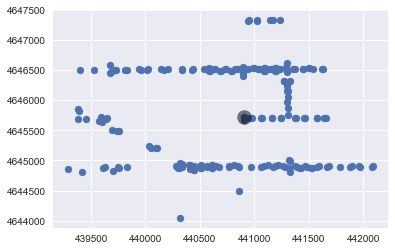

In [16]:
from sklearn.metrics import pairwise_distances_argmin_min # to find closest terminal to center

clustData = kData[0]
loc = clustData['locations']
dem = clustData['demand']
start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
labs = clustData['labels']
depot = labs.index(clustData['centralTerm']) # find the starting drop-off point
ca = clustData['cars']
street_name = clustData['streetName']
street_side = clustData['streetSide']
print(depot)
print(clustData['centralTerm'])
print(labs[0])
print(len(loc))


X = np.array(zip([x[0] for x in loc],[x[1] for x in loc]))

plt.scatter(X[:, 0], X[:, 1])
# print(ca)
# print(dem)
# centers = kmeans.cluster_centers_
plt.scatter(loc[depot][0], loc[depot][1], c='black', s=200, alpha=0.5)


# Run the optimization

## Output is in the following format:

Route PERSON ID Load CUMUALTIVE NUMBER OF TICKETS Time SECONDS FROM START -> NEXT NODE

In [24]:
# Establish running parameters of model
noEmps = 10
params = {'locations': loc, 'demands':dem, 'start_times':start_times, 'end_times':end_times, \
                 'num_vehicles':noEmps, 'search_time_limit': 30000,'horizon' : int(5 * 3600), \
                 'time_per_demand_unit' : 2*60, 'speed' : 1.34, 'VehicleCapacity' : 999999,\
                'depot' : depot, 'time_per_car_unit':1*60, 'labs':labs, 'cars' : ca, 'blockOverhead' : 2*60, \
          'street_crossing_penalty' : 60, 'street_name':street_name, 'street_side':street_side, \
         'distance_constraint': 10000, 'blockSizeX' : int(0.3048 * 600), 'blockSizeY' : int(0.3048 * 600) ,\
         'distanceCrossingPenalty' : False} #20922

In [25]:
solByCar, assignment = parktimize(**params)


Total distance of all routes: 31391

Route 0: starting by termial: B520127 Load(0) Time(0) ->  starting by termial: B520127 Load(0) Time(120)


Cost(0..9223372036854775807)
Route 1: starting by termial: B520127 Load(0) Time(0) ->  starting by termial: B520127 Load(0) Time(120)


Cost(0..9223372036854775807)
Route 2: starting by termial: B520127 Load(0) Time(0) ->  starting by termial: B520127 Load(0) Time(120)


Cost(0..9223372036854775807)
Route 3: starting by termial: B520127 Load(0) Time(0) ->  starting by termial: B520127 Load(0) Time(120)


Cost(0..9223372036854775807)
Route 4: starting by termial: B520127 Load(0) Time(0) ->  B501116 Load(0) Time(1045) ->  B501101 Load(0) Time(1480) ->  B501102 Load(0) Time(1807) ->  B501114 Load(0) Time(2167) ->  B501103 Load(0) Time(2665) ->  B501111 Load(0) Time(3097) ->  B501104 Load(0) Time(3599) ->  B501105 Load(0) Time(3991) ->  B501106 Load(0) Time(4546) ->  B502101 Load(0) Time(4973) ->  B502102 Load(0) Time(5470) ->  B502103 Load(0) Time

In [54]:
#  FIELDS: solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime, totCrossings))


def getDataForAgent(x):
    solX = solByCar[x]
    solDict = {'locations': solX[0], 'time': solX[2], 'travel time':solX[3], 'ticket writing time': solX[4] ,\
              'car checking time': solX[5], 'block checkin time':solX[6],'crossing time':solX[8],\
               'crossings': solX[7], 'tickets': solX[1], 'total distance': solX[9]}
    return pd.DataFrame.from_dict(solDict)

getDataForAgent(7)

,block checkin time,car checking time,crossing time,crossings,locations,ticket writing time,tickets,time,total distance,travel time
0,0,0,0,0,B520127,0,0,0,0,0
1,120,25,420,7,B460101,6,0,1522,1275,951
2,240,136,480,8,B460112,36,0,1860,1298,968
3,360,220,540,9,B460102,96,0,2235,1366,1019
4,480,307,660,11,B460106,150,0,2853,1684,1256
5,600,455,660,11,B460103,301,1,3292,1712,1276
6,720,722,840,14,B524102,577,3,4644,2394,1785
7,840,794,840,14,B524101,602,3,4957,2523,1881
8,960,998,900,15,B503109,722,4,5613,2726,2033
9,1080,1068,960,16,B503108,755,4,5919,2757,2056


# How to fix redundant depot visit? create dummy depot staring point based on closest location with 0 ticket demand

# WARNING - DO NOT RUN THIS MORE THAN ONCE, OR IT WILL KEEP APPENDING NEW LIST ITEMS

In [28]:
def getData(cluster):
    clustData = kData[cluster]
    loc = clustData['locations']
    dem = clustData['demand']
    labs = clustData['labels']
    ca = clustData['cars']
    street_side = clustData['streetSide']
    street_name = clustData['streetName']
    #TODO: implement the LAZ GARAGE IF CLUSTERID = N-CLUSTERS
    if cluster == nClusters:
        loc.append([448476.6, 4636929])
        dem.append(0)
        ca.append(0)
        labs.append('starting by termial: LAZ GARAGE')
        street_name.append("NA")
        street_side.append("NA")
        depot = len(loc) - 1

    #begin appending of dummy start point
    else:
        loc.append(loc[labs.index(clustData['centralTerm'])])
        dem.append(0)
        ca.append(0)
        labs.append('starting by termial: ' + clustData['centralTerm'])
        street_name.append(street_name[labs.index(clustData['centralTerm'])])
        street_side.append(street_side[labs.index(clustData['centralTerm'])])
        depot = len(loc) - 1
    start_times =  [0] * len(demands)
    end_times = [3600 * 24] * len(start_times)
    return loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side


   # The empUp function loops through number of enforcement agents until it finds the minimal viable needed employees per cluster

In [42]:
def empUp():    
    noEmps = 0
    solByCar = None
    while solByCar is None and noEmps < 50:
        try:
            noEmps += 1
            print("trying # of employees : " + str(noEmps))
            solByCar, assignment = parktimize(num_vehicles=noEmps, locations=loc, demands=dem, \
        start_times=start_times, end_times=end_times, search_time_limit = 20000,\
        horizon = int(6.5 * 3600), time_per_demand_unit = 3*60, speed = 1.34,
        depot = depot, time_per_car_unit=1*60, labs=labs, cars=ca, blockOverhead = 2 * 60, \
         street_crossing_penalty = 60, street_name=street_name, street_side=street_side, \
         distance_constraint = 20922, blockSizeX = int(0.3048 * 600), blockSizeY = int(0.3048 * 600))
        except:
             pass
    return solByCar, noEmps

# Now run the optimization for all clusters

In [43]:
for k in range(nClusters + 1):
# k = nClusters
    print("Starting cluster {} of {}".format(k, nClusters))
    loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side = getData(k)
    solution, noEmps = empUp()
    kData[k].update({'solution': solution, 'empsNeeded': noEmps})

Starting cluster 0 of 1
trying # of employees : 1
No solution found.
trying # of employees : 2
No solution found.
trying # of employees : 3
No solution found.
trying # of employees : 4
No solution found.
trying # of employees : 5
Total distance of all routes: 26884

Route 0: starting by termial: B520127 Load(0) Time(0) ->  B520126 Load(0) Time(157) ->  B456113 Load(0) Time(1286) ->  B456114 Load(0) Time(1505) ->  B456115 Load(0) Time(1804) ->  B456116 Load(0) Time(2017) ->  B456155 Load(0) Time(2375) ->  B456118 Load(0) Time(2649) ->  B456125 Load(0) Time(2964) ->  B456120 Load(0) Time(3172) ->  B456122 Load(0) Time(3392) ->  B456123 Load(0) Time(3689) ->  B456124 Load(0) Time(4021) ->  B525105 Load(1) Time(4534) ->  B525108 Load(1) Time(5072) ->  B525109 Load(1) Time(5280) ->  B525101 Load(1) Time(5478) ->  B525102 Load(1) Time(5730) ->  B525103 Load(1) Time(5954) ->  B525107 Load(2) Time(6511) ->  B525106 Load(2) Time(6968) ->  B525104 Load(2) Time(7381) ->  B456101 Load(2) Time(7745

No solution found.
trying # of employees : 16
No solution found.
trying # of employees : 17
No solution found.
trying # of employees : 18
No solution found.
trying # of employees : 19
No solution found.
trying # of employees : 20
No solution found.
trying # of employees : 21
No solution found.
trying # of employees : 22
No solution found.
trying # of employees : 23
No solution found.
trying # of employees : 24
No solution found.
trying # of employees : 25
No solution found.
trying # of employees : 26
No solution found.
trying # of employees : 27
No solution found.
trying # of employees : 28
No solution found.
trying # of employees : 29
No solution found.
trying # of employees : 30
No solution found.
trying # of employees : 31
No solution found.
trying # of employees : 32
No solution found.
trying # of employees : 33
No solution found.
trying # of employees : 34
No solution found.
trying # of employees : 35
No solution found.
trying # of employees : 36
No solution found.
trying # of emp

# Write the solutions to file

In [ ]:
import pickle
import datetime

now = datetime.datetime.now()

filename = "solutionFile" + now.strftime("%Y-%m-%d %H:%M") + ".pickle"
with open(filename, 'wb') as handle:
    pickle.dump(kData, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(filename + " saved")

In [44]:
#         solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime))

# {'locations': solX[0], 'time': solX[2], 'travel time':solX[3], 'ticket writing time': solX[4] ,\
#               'car checking time': solX[5], 'block checkin time':solX[6],'crossing time':solX[8],\
#                'crossings': solX[7], 'tickets': solX[1], 'total distance': solX[9]}


bid = []
time = []
personID = 1
people = []
clus = []
origin = []
ro = []
travTime = []
blockCheckTime = []
ticketWritingTime = []
carCheckTime = []
tickets = []
crossings = []
xTime = []
dist = []

for k in range(nClusters+1):
    try:
        for person in kData[k]['solution']:
            o = []
            for p in person[0]:
                if p.startswith("starting"):
                    o.append("True")
                else:
                    o.append("False")
            origin.extend(o)
            rr = range(len(person[0]))
            ro.extend(rr)
            bid.extend(person[0])
            time.extend(person[2])
            travTime.extend(person[3])
            blockCheckTime.extend(person[6])
            crossings.extend(person[7])
            ticketWritingTime.extend(person[4])
            carCheckTime.extend(person[5])
            tickets.extend([x / time_per_ticket for x in person[4]])
            xTime.extend(person[8])
            dist.extend(person[9])
            pp = [personID] * len(person[0])
            people.extend(pp)
            personID += 1
            clusta = [k] * len(person[0])
            clus.extend(clusta)
    except:
        pass
len(people)

208

In [19]:

import pickle
import datetime

now = datetime.datetime.now()
finalDFDict = {'origin_flg': origin, 'Cluster ID': clus, 'Route ID': people, \
               'Block ID': bid, 'Expected Time': time, "Route ID": people, "RouteOrder": ro, \
              'travel time': travTime, 'block check time': blockCheckTime, 'ticket writing time': ticketWritingTime,\
              'car check time': carCheckTime, 'total tickets': tickets, 'street crossings' : crossings, \
              'crossing time': xTime, 'distance': dist}


finalData = pd.DataFrame.from_dict(finalDFDict)


filename = os.path.join("output", "routeFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv")

finalData

NameError: name 'origin' is not defined

In [ ]:
finalData.groupby('Cluster ID')['Route ID'].nunique()
